In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Creating Necessary Functions

In [134]:
def preprocess(df):
    """
    Preprocess the data removing uncessary data and setting elements to their correct types
    Handle Null values by backward fill null values
    Creating Features for our model training
    """
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)#remove empty column
    if df.index.name != 'Date':    
        df['Date'] = pd.to_datetime(df['Date']) #update column from string to datetime
        df.set_index('Date', inplace=True) 
        df = df.sort_index()
    df.bfill( inplace=True)
    return df

In [135]:
def feature_engineering(df):
    """
    Creating new features and concatentating other features
    Also using MinMaxScaler to Normalize the features between 0 and 1 to ensure large values are not weighted higher. 
    """
    df['Month'] = df.index.month #create a month feature to account for seasonality
    df['Week'] = df.index.isocalendar().week #create a week feature to account for seasonality
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter 

    features_to_scale = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
    scaler = MinMaxScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    df['Size_Type'] = df['Size'] * df['Type'] #concatenating the 2 highly correlated features in to one.

    return df

In [136]:
def add_lags(df):
    # Sort the DataFrame by 'Store', 'Dept', and 'Date' (assuming 'Date' is index)
    df = df.sort_values(by=['Store', 'Dept', 'Date'])

    # Define a function to add lagged features
    def add_lag_feature(df, lag_weeks, lag_name):
        df[lag_name] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(periods=lag_weeks)
        return df

    # Add lag features
    df = add_lag_feature(df, 1, 'lag1')   # 1 week back
    df = add_lag_feature(df, 5, 'lag2')   # 5 weeks back (1 month approx)
    df = add_lag_feature(df, 52, 'lag3')  # 1 year back

    df.fillna(0, inplace=True)  # Fill NaNs with zero
    return df

## Data Preprocessing
- Use the functions that we defined above to preprocess data, add features and add lags features
- Define Features and Target for the Model
- Use a simple train_test_split to get train, validation, and test sets for our model training

In [137]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)
df = feature_engineering(df)
df = add_lags(df)

In [138]:
df.index.unique()
df.groupby('Date').size().mean()

2948.041958041958

In [139]:
features = ['Store', 'Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

In [140]:
df.shape

(421570, 23)

In [141]:
# Check for NaNs before sequence creation
print("NaNs in DataFrame before creating sequences:", df.isna().sum().sum())

NaNs in DataFrame before creating sequences: 0


In [142]:
def create_sequences(data, window=10):
    X = []
    y = []
    # Group data by Store and Dept
    grouped = data.groupby(['Store', 'Dept'])
    
    for _, group in grouped:
        # Sort the group by Date to maintain chronological order
        group = group.sort_index()
        # Iterate over the group to create sequences
        for i in range(len(group) - window):
            # Select a window of data points
            X_window = group.iloc[i:i+window].drop(['Store', 'Dept'], axis=1).values
            # Append to X as a single sequence
            X.append(X_window)
            # Select the target value
            y_value = group.iloc[i + window]['Weekly_Sales']
            y.append(y_value)
    
    return np.array(X), np.array(y)

X, y = create_sequences(df)

In [143]:
# Convert to float32 for NaN check
X = X.astype(np.float32)
y = y.astype(np.float32)

# Check for NaNs in sequences
print("NaNs in sequences:", np.isnan(X).sum(), np.isnan(y).sum())

NaNs in sequences: 0 0


In [144]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [145]:
y.shape

(389257,)

In [146]:
X_train = np.array([[np.array(x, dtype=np.float32) for x in row] for row in X_train])
X_test = np.array([[np.array(x, dtype=np.float32) for x in row] for row in X_test])
X_val = np.array([[np.array(x, dtype=np.float32) for x in row] for row in X_val])

## Creating the LSTM Model

In [147]:
nn_model = Sequential()
nn_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
nn_model.add(Dropout(0.2))
nn_model.add(LSTM(units=50, return_sequences=False))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(units=1, activation='linear'))

nn_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\nmarr\OneDrive\Documents\GitHub\Demand-Forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training The Model
- Train with training and validation set
- Test with Test set

In [148]:
history = nn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 832667840.0000 - val_loss: 553297408.0000
Epoch 2/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 813680896.0000 - val_loss: 541038464.0000
Epoch 3/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 93s 10ms/step - loss: 804896768.0000 - val_loss: 529118848.0000
Epoch 4/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 782124992.0000 - val_loss: 517515552.0000
Epoch 5/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - loss: 775026624.0000 - val_loss: 506237216.0000
Epoch 6/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step - loss: 764007424.0000 - val_loss: 495261152.0000
Epoch 7/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step - loss: 751029952.0000 - val_loss: 484590656.0000
Epoch 8/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 737597888.0000 - val_loss: 474158272.0000
Epoch 9/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - loss: 725562176.0000 - val_loss: 464028352.0000
Epoch 10/30
9732/9732 ━━━━━━━━━━━━━━━━━━━━ 89s 9m

### Testing on Subset of Data

In [192]:
y_pred = nn_model.predict(X_val)

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


In [194]:
test_dates = df.index[-len(X_val):]

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


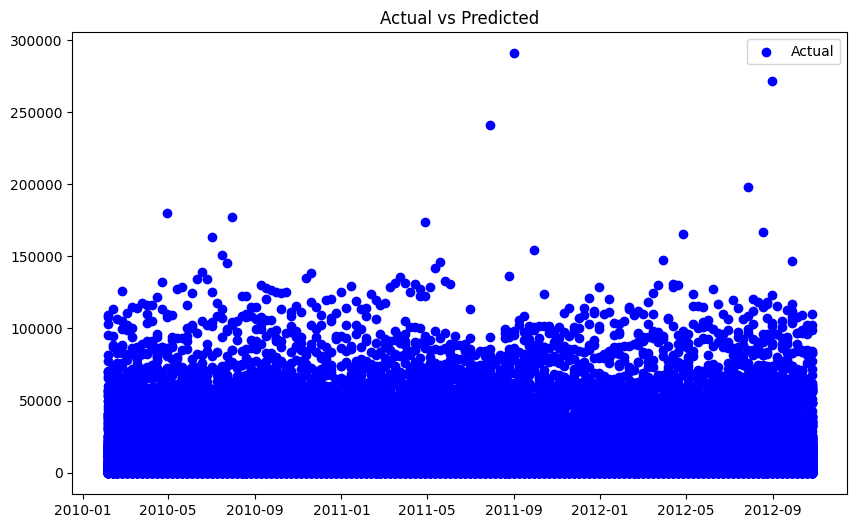

In [198]:
plt.figure(figsize=(10, 6))
plt.scatter(test_dates, y_val, label='Actual', color='blue')
plt.scatter(test_dates, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [151]:
start_date = '2012-08-01'
end_date = '2012-09-01'
filtered_df = df.loc[start_date:end_date]
y_pred = y_pred.loc[start_date:end_date]

ax = filtered_df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data')
y_pred.plot(ax=ax, style='.', label='Predictions')

plt.legend()
plt.title('Data vs Predicted Data (August 2012)')
plt.show()

KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

In [ ]:
loss = nn_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: nan
Test Loss: nan
